In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
from os.path import join
import networkx as nx
from importlib import reload

from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
from geospatial_utils import load_config
from num2words import num2words
import transport_flow_and_disruption_functions as tfdf


# global settings
COST = 'time_m'
THRESH = 60
TRUNC_THRESH = .99
ZETA = 1
EDGE_ATTRS = ['edge_id', 'length_m', 'time_m']
RECALCULATE_PATHS = True
RECALCULATE_TRAFFIC = False
COUNTRY = 'LCA'
plot_kwargs = {'dpi': 400, 'bbox_inches': 'tight'}
caribbean_epsg = 32620

In [37]:
# load school districts (slightly different file formats)
CONFIG = load_config(join("..", "..", ".."))

datadir, resultsdir, figdir = CONFIG['paths']['data'], CONFIG['paths']['results'], CONFIG['paths']['figures']

# load roads, roads network, and schools
roads, road_net = tfdf.get_roads(join(datadir, 'infrastructure', 'transport'), COUNTRY, ['edge_id', 'length_m', 'time_m'])
roads = roads.to_crs(epsg=caribbean_epsg)
roads = roads[['osm_id', 'edge_id', 'from_node', 'to_node', 'length_m', 'geometry', 'time_m', 'from_pop', 'to_pop']]


schools = gpd.read_file(join(datadir, 'infrastructure', 'social', 'education.gpkg'))
schools = schools[schools['iso_code'] == COUNTRY]
schools = schools[['osm_id', 'node_id', 'school_district', 'assigned_students', 'geometry']]

if COUNTRY == 'LCA':
    admin_areas = gpd.read_file(join(datadir, 'infrastructure', 'social', f'{COUNTRY.lower()}_edu_districts.gpkg'), layer='areas')[["DIS","geometry"]]
    admin_areas.loc[:, "DIS"] = admin_areas.apply(lambda x: str(num2words(x["DIS"])).title(), axis=1)
    admin_areas.rename(columns={"DIS": "school_district"},inplace=True)
elif COUNTRY == "VCT":
    admin_areas = gpd.read_file(os.path.join(datadir, 'infrastructure', 'social', f'{COUNTRY.lower()}_edu_districts.gpkg'))[["SCHOOL_DIST","geometry"]]
    admin_areas["SCHOOL_DIST"] = admin_areas.apply(lambda x: str(num2words(x["SCHOOL_DIST"])).title(),axis=1)
    admin_areas.rename(columns={"SCHOOL_DIST": "school_district"},inplace=True)
# TODO: GRD and DMA
admin_areas = admin_areas.to_crs(epsg=caribbean_epsg)
admin_areas.loc[:, "school_district"] = admin_areas["school_district"].astype(str).str.replace("Saint","St.")

loading config file from ../../...
Number of nodes: 8,275
Number of edges: 9,263


9328
9328


<Axes: >

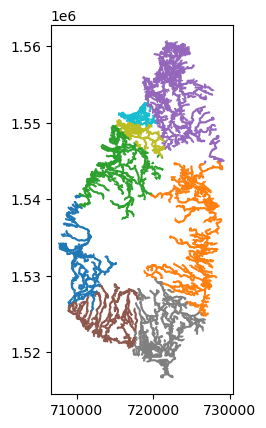

In [39]:
roads_district = get_origin_intersection(roads, admin_areas, **{'how': 'inner', 'distance_col': None})
print(len(roads))
print(len(roads_district))
roads_district.plot('school_district', categorical=True)

In [101]:
origin_geoms = {origin: geom for origin, geom in zip(roads['from_node'], roads['origin'])}
dest_geoms = {origin: geom.centroid for origin, geom in zip(schools['node_id'], schools['geometry'])}

path_df['origin_geom'] = path_df['origin_id'].apply(lambda x: origin_geoms[x])
path_df['dest_geom'] = path_df['destination_id'].apply(lambda y: dest_geoms.get(y, np.nan))

In [114]:
from shapely.geometry import LineString

path_df = path_df.dropna(subset=['origin_geom', 'dest_geom'])

path_df['direct'] = path_df.apply(lambda row: LineString([row.origin_geom, row.dest_geom]), axis=1)

/var/folders/7w/k72v6f5x25gblsqmh6bxd3j40000gn/T/ipykernel_65681/427865172.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  path_df['direct'] = path_df.apply(lambda row: LineString([row.origin_geom, row.dest_geom]), axis=1)


<Axes: >

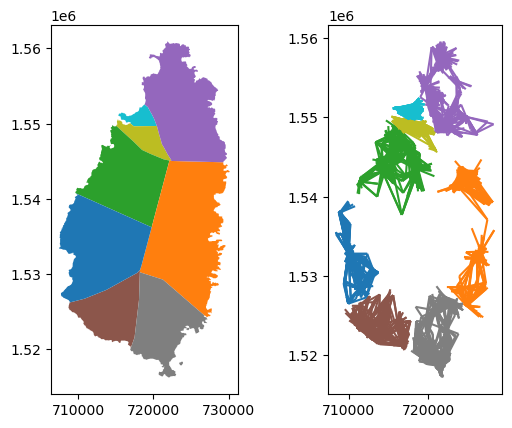

In [119]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2)

admin_areas.plot('school_district', categorical=True, ax=ax[0])
path_df.set_geometry('direct').plot('school_district', categorical=True, ax=ax[1])

In [120]:
from analysis_utils import get_nearest_values

def process_school_fluxes(roads, road_net, schools, admin_areas, resultsdir, COUNTRY, COST, THRESH, ZETA, RECALCULATE_PATHS, TRUNC_THRESH):

    # assign domestic classes for road network
    roads_district = get_origin_intersection(roads, admin_areas, **{'how': 'inner', 'distance_col': None})
    domestic_classes = {node_id: f"domestic_{school_district}" for node_id, school_district in zip(roads_district['from_node'], roads_district['school_district'])}

    # locate dest nodes nearest to schools
    roads_district['dest'] = roads_district.geometry.apply(lambda x: Point(x.coords[-1]))
    schools.loc[:, 'nearest_node'] = schools.apply(lambda x: get_nearest_values(x, roads_district.set_geometry('dest'), 'to_node'), axis=1)
    aggfunc = {'node_id': lambda x : '_and_'.join(x), 'assigned_students': sum, 'school_district': pd.Series.mode}
    nearest_nodes = schools[['nearest_node', 'node_id', 'assigned_students', 'school_district']].groupby('nearest_node').agg(aggfunc).reset_index()

    # prepare to add school ids, school populations and node classes to the network
    rename_schools = {node_id: school_id for node_id, school_id in zip(nearest_nodes['nearest_node'], nearest_nodes['node_id'])}
    school_pops = {school_id: school_pop for school_id, school_pop in zip(nearest_nodes['node_id'], nearest_nodes['assigned_students'])}
    school_classes = {school_id: f"school_{school_district}" for school_id, school_district in zip(nearest_nodes['node_id'], nearest_nodes['school_district'])}

    # modify networkx road network
    road_net = nx.relabel_nodes(road_net, rename_schools, copy=True)
    nx.set_node_attributes(road_net, school_pops, name="population")
    nx.set_node_attributes(road_net, domestic_classes, name="class")
    nx.set_node_attributes(road_net, school_classes, name="class")
    
    # calculate paths from households to schools
    paths_df = []
    for district in admin_areas['school_district'].unique():
        path_df = tfdf.get_flux_data(road_net, COST, THRESH, ZETA, origin_class=f"domestic_{district}", dest_class=f"school_{district}", class_str='class')
        path_df.loc[:, 'school_district'] = district
        paths_df.append(path_df)
    path_df = pd.concat(paths_df)
    path_df, *_ = tfdf.truncate_by_threshold(path_df, threshold=TRUNC_THRESH)


    # get path data and subdivided road network
    if RECALCULATE_PATHS:
        paths_df = pd.concat(paths_df)
        paths_df, *_ = truncate_by_threshold(paths_df, threshold=TRUNC_THRESH)
        paths_df.to_parquet(path=f"{pathname}.parquet", index=True)
    else:
        paths_df = pd.read_parquet(path=f"{pathname}.parquet", engine="fastparquet")

    return paths_df, road_net

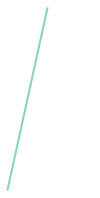

In [110]:
LineString([path_df.origin_geom[62211], path_df.dest_geom[62211]])

In [ ]:
path_df.set_geom